In [1]:
import sys
import os

IN_COLAB = False
DATA_PATH = "data/"

# if in colab, make colab setup
if 'google.colab' in sys.modules:
    
    IN_COLAB = True
    SSH_DIR = '/root/.ssh'
    ZIP_PATH = "/content/drive/MyDrive/embedded_ml_data/VOCdevkit.zip"
    FILENAME = "dev-notebook.ipynb"
    BRANCH = "michael"

    # Setup ssh-auth to github
    try:
        os.makedirs(SSH_DIR)
    except FileExistsError:
        # directory already exists
        pass

    !ssh-keyscan github.com >> /root/.ssh/known_hosts
    !echo 'PUBKEY' > /root/.ssh/id_rsa.pub
    !echo -e "PRIVKEY" > /root/.ssh/id_rsa
    !chmod 644 /root/.ssh/known_hosts
    !chmod 600 /root/.ssh/id_rsa
    !ssh -T git@github.com

    # Setup working environment
    !rm -rf models
    !rm -rf utils
    !git clone -b $BRANCH https://github.com/yannickfunk/EmbeddedMLLab tmp
    !rm tmp/$FILENAME
    !mv tmp/* .
    !rm -rf tmp
    !rm -rf sample_data
    %pip install -r requirements.txt

    # Setup data
    from google.colab import drive
    drive.mount('/content/drive')
    try:
      os.makedirs('./data')
    except FileExistsError:
      # directory already exists
      pass
    !cp  $ZIP_PATH data/
    %pushd data
    !unzip -qq VOCdevkit.zip
    %popd
    drive.flush_and_unmount()

    
try:
    os.makedirs('./checkpoints')
    os.makedirs('./checkpoints/results')
except FileExistsError:
    # directory already exists
    pass


Prepare Tensorboard logger

In [2]:
# Setup logger
import pytorch_lightning as pl

LOGDIR='logs'
TENSORBOARD_DIR=LOGDIR+'/lightning_logs'

tensorboard = pl.loggers.TensorBoardLogger(save_dir=LOGDIR, default_hp_metric=True, log_graph=True)

try:
    os.makedirs('./'+LOGDIR+'/lightning_logs')
except FileExistsError:
    # directory already exists
    pass
 

/opt/conda/envs/eml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext tensorboard
%tensorboard --logdir $TENSORBOARD_DIR

Prepare model

In [6]:
from models.tinyyolov2 import TinyYoloV2PersonOnly
import pytorch_lightning as pl
import torch

from utils.dataloader import VOCDataModule

from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import nni
from nni.compression.pytorch import LightningEvaluator


# Setting up callbacks
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping = EarlyStopping(monitor="val_loss", mode='min', verbose=True)
checkpointing = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    verbose=True,
    auto_insert_metric_name=True,
    save_last=True
)

trainer = nni.trace(pl.Trainer)(
    max_epochs=15,
    auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    accelerator="auto",
    devices=[0] if torch.cuda.is_available() else None,
    accumulate_grad_batches=1,
    logger=tensorboard,
    log_every_n_steps=1,
    fast_dev_run= True if not torch.cuda.is_available() else False,
    callbacks=[
    lr_monitor,
    early_stopping,
    checkpointing
    ]
)


model = TinyYoloV2PersonOnly()
model.load_pt_from_disk(DATA_PATH + "/voc_pretrained.pt")

data = nni.trace(VOCDataModule)(person_only=True)

evaluator = LightningEvaluator(trainer, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Tune and train model

In [7]:
evaluator.trainer.fit(model,data)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

   | Name  | Type            | Params
-------------------------------------------
0  | loss  | YoloLoss        | 0     
1  | pad   | ReflectionPad2d | 0     
2  | conv1 | Conv2d          | 432   
3  | bn1   | BatchNorm2d     | 32    
4  | conv2 | Conv2d          | 4.6 K 
5  | bn2   | BatchNorm2d     | 64    
6  | conv3 | Conv2d          | 18.4 K
7  | bn3   | BatchNorm2d     | 128   
8  | conv4 | Conv2d          | 73.7 K
9  | bn4   | BatchNorm2d     | 256   
10 | conv5 | Conv2d          | 294 K 
11 | bn5   | BatchNorm2d     | 512   
12 | conv6 | Conv2d          | 1.2 M 
13 | bn6   | BatchNorm2d     | 1.0 K 
14 | conv7 | Conv2d          | 4.7 M 
15 | bn7   | BatchNorm2d     | 2.0 K 
16 | conv8 | Conv2d          | 9.4 M 
17 | bn8   | BatchNorm2d     | 2.0 K 
18 | conv9 | Conv2d          | 30.8 K
-------------------------------------------
9.5 M     Trainable params
6.3 M     Non-t

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/eml/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=60.2, v_num=1]

Metric val_loss improved. New best score: 49.442


Epoch 0: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=60.2, v_num=1]

Epoch 0, global step 17: 'val_loss' reached 49.44175 (best 49.44175), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=0-step=17.ckpt' as top 3


Epoch 1: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=43, v_num=1]  

Metric val_loss improved by 16.247 >= min_delta = 0.0. New best score: 33.194


Epoch 1: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=43, v_num=1]

Epoch 1, global step 34: 'val_loss' reached 33.19437 (best 33.19437), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=1-step=34.ckpt' as top 3


Epoch 2: 100%|██████████| 35/35 [00:30<00:00,  1.13it/s, loss=30.4, v_num=1]

Metric val_loss improved by 10.179 >= min_delta = 0.0. New best score: 23.015


Epoch 2: 100%|██████████| 35/35 [00:30<00:00,  1.13it/s, loss=30.4, v_num=1]

Epoch 2, global step 51: 'val_loss' reached 23.01501 (best 23.01501), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=2-step=51.ckpt' as top 3


Epoch 3: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=20.7, v_num=1]

Metric val_loss improved by 7.179 >= min_delta = 0.0. New best score: 15.836


Epoch 3: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s, loss=20.7, v_num=1]

Epoch 3, global step 68: 'val_loss' reached 15.83590 (best 15.83590), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=3-step=68.ckpt' as top 3


Epoch 4: 100%|██████████| 35/35 [00:31<00:00,  1.13it/s, loss=15, v_num=1]  

Metric val_loss improved by 3.679 >= min_delta = 0.0. New best score: 12.157


Epoch 4: 100%|██████████| 35/35 [00:31<00:00,  1.13it/s, loss=15, v_num=1]

Epoch 4, global step 85: 'val_loss' reached 12.15701 (best 12.15701), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=4-step=85.ckpt' as top 3


Epoch 5: 100%|██████████| 35/35 [00:33<00:00,  1.03it/s, loss=11.4, v_num=1]

Metric val_loss improved by 2.376 >= min_delta = 0.0. New best score: 9.781


Epoch 5: 100%|██████████| 35/35 [00:33<00:00,  1.03it/s, loss=11.4, v_num=1]

Epoch 5, global step 102: 'val_loss' reached 9.78106 (best 9.78106), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=5-step=102.ckpt' as top 3


Epoch 6: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=9.12, v_num=1]

Metric val_loss improved by 1.692 >= min_delta = 0.0. New best score: 8.089


Epoch 6: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=9.12, v_num=1]

Epoch 6, global step 119: 'val_loss' reached 8.08901 (best 8.08901), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=6-step=119.ckpt' as top 3


Epoch 7: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=7.52, v_num=1]

Metric val_loss improved by 1.134 >= min_delta = 0.0. New best score: 6.955


Epoch 7: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=7.52, v_num=1]

Epoch 7, global step 136: 'val_loss' reached 6.95453 (best 6.95453), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=7-step=136.ckpt' as top 3


Epoch 8: 100%|██████████| 35/35 [00:32<00:00,  1.06it/s, loss=6.41, v_num=1]

Metric val_loss improved by 0.866 >= min_delta = 0.0. New best score: 6.089


Epoch 8: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s, loss=6.41, v_num=1]

Epoch 8, global step 153: 'val_loss' reached 6.08873 (best 6.08873), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=8-step=153.ckpt' as top 3


Epoch 9: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=5.61, v_num=1]

Metric val_loss improved by 0.633 >= min_delta = 0.0. New best score: 5.455


Epoch 9: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=5.61, v_num=1]

Epoch 9, global step 170: 'val_loss' reached 5.45525 (best 5.45525), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=9-step=170.ckpt' as top 3


Epoch 10: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=4.99, v_num=1]

Metric val_loss improved by 0.508 >= min_delta = 0.0. New best score: 4.947


Epoch 10: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=4.99, v_num=1]

Epoch 10, global step 187: 'val_loss' reached 4.94745 (best 4.94745), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=10-step=187.ckpt' as top 3


Epoch 11: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=4.49, v_num=1]

Metric val_loss improved by 0.384 >= min_delta = 0.0. New best score: 4.564


Epoch 11: 100%|██████████| 35/35 [00:31<00:00,  1.12it/s, loss=4.49, v_num=1]

Epoch 11, global step 204: 'val_loss' reached 4.56359 (best 4.56359), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=11-step=204.ckpt' as top 3


Epoch 12: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=4.11, v_num=1]

Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 4.222


Epoch 12: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=4.11, v_num=1]

Epoch 12, global step 221: 'val_loss' reached 4.22204 (best 4.22204), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=12-step=221.ckpt' as top 3


Epoch 13: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s, loss=3.79, v_num=1]

Metric val_loss improved by 0.269 >= min_delta = 0.0. New best score: 3.953


Epoch 13: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s, loss=3.79, v_num=1]

Epoch 13, global step 238: 'val_loss' reached 3.95331 (best 3.95331), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=13-step=238.ckpt' as top 3


Epoch 14: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=3.52, v_num=1]

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 3.742


Epoch 14: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=3.52, v_num=1]

Epoch 14, global step 255: 'val_loss' reached 3.74184 (best 3.74184), saving model to 'logs/lightning_logs/version_1/checkpoints/epoch=14-step=255.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=3.52, v_num=1]


100%|██████████| 350/350 [01:13<00:00,  4.75it/s]


average precision:  0.36512493384206335


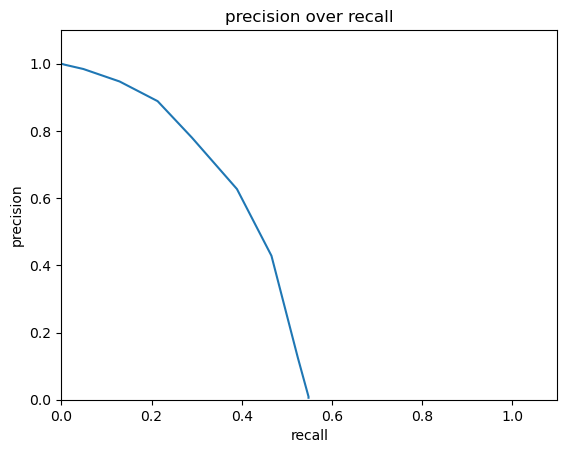

In [8]:
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes
from utils.dataloader import VOCDataLoaderPerson

import torch
import numpy as np
import tqdm


test_loader = VOCDataLoaderPerson(train=False, batch_size=1, data_path=DATA_PATH, n_limit=350)

test_precision = []
test_recall = []

for inputs, targets in tqdm.tqdm(test_loader, total=350):
    with torch.no_grad():
        outputs = model(inputs)

    #The right threshold values can be adjusted for the target application
    outputs = filter_boxes(outputs, 0.0)
    outputs = nms(outputs, 0.5)
    outputs = torch.tensor(np.array(outputs))

    precision, recall = precision_recall_levels(targets[0], outputs[0])
    test_precision.append(precision)
    test_recall.append(recall)

avg_precision = ap(test_precision, test_recall)
print("average precision: ", avg_precision)
display_roc(test_precision, test_recall)